Implementing the code described at http://nbviewer.jupyter.org/github/metamath1/ml-simple-works/blob/master/GAN/GANs.ipynb?flush_cache=true

In [65]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab

from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input
from keras import optimizers
from keras.utils import np_utils



In [66]:

#np.random.seed(78)
#np.random.seed(0)

batch_size = 200
print_interval = 500

def make_trainable(net, val):
    net.trainable = val
    for l in net.layers:
        l.trainable = val



학습 데이터를 생성한다. 

In [67]:
mu, sigma = 6, 1.25

def get_distribution_sampler(mu,sigma,N):
    data_xp, data_yp = np.random.normal(mu,sigma,N), np.ones(N)
    data_p = np.vstack((data_xp,data_yp)).T

    return data_p



In [1]:

D = Sequential()
D.add(Dense(30,activation='relu', input_dim = 1))
D.add(Dense(30,activation='relu'))
D.add(Dense(2,activation='softmax'))
D_opt = optimizers.Adam(lr=0.001*1.58, beta_1=0.9,beta_2=0.999, epsilon=1e-08,decay=0.0)
D.compile(loss='binary_crossentropy',optimizer=D_opt, metrics=['accuracy'])
D.summary()



NameError: name 'Sequential' is not defined

In [69]:
# Generator 

G = Sequential()
G.add(Dense(20, input_dim=1))
G.add(Activation('sigmoid'))
G.add(Dense(40))
G.add(Activation('sigmoid'))
G.add(Dense(1))
G.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_19 (Dense)             (None, 20)                40        
_________________________________________________________________
activation_7 (Activation)    (None, 20)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 40)                840       
_________________________________________________________________
activation_8 (Activation)    (None, 40)                0         
_________________________________________________________________
dense_21 (Dense)             (None, 1)                 41        
Total params: 921
Trainable params: 921
Non-trainable params: 0
_________________________________________________________________


In [70]:

# GAN - phase 1 --- D(G(z))

make_trainable(D,False)
gan_input = Input(shape=[1])
GAN = Model ( gan_input, D(G(gan_input)))
G_opt = optimizers.Adam(lr=0.001*1.1, beta_1 = 0.9, beta_2=0.999, epsilon=1e-08,decay=0.0)
GAN.compile(loss='mean_squared_logarithmic_error', optimizer=G_opt)
GAN.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
sequential_7 (Sequential)    (None, 1)                 921       
_________________________________________________________________
sequential_6 (Sequential)    (None, 2)                 1052      
Total params: 1,973
Trainable params: 921
Non-trainable params: 1,052
_________________________________________________________________


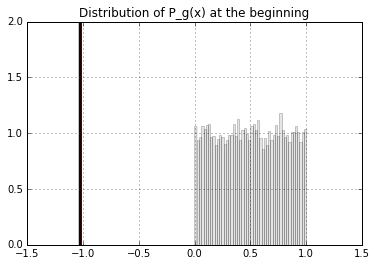

G produced value 10개
[[-1.02998579]
 [-1.02997947]
 [-1.02813637]
 [-1.03238475]
 [-1.03066957]
 [-1.02794695]
 [-1.03246534]
 [-1.03157389]
 [-1.02901053]
 [-1.0274812 ]]


In [71]:

Z1 = np.random.uniform(0,1,10000)
fake1 = G.predict(Z1)
n, bins1, patches = plt.hist(Z1, 50 , normed=1, facecolor='grey', alpha=0.2)
plt.title('Distribution of P_g(x) at the beginning')
n, bins, patches = plt.hist(fake1, 50, normed=1, facecolor='red', alpha=0.5)
plt.grid(True)
plt.axis([-1.5,1.5,0,2])
plt.show()
print("G produced value 10개")
print(fake1[:10])


Discriminator 를 미리 한번 학습시켜본다.. 

In [72]:
make_trainable(D,True)

k = 200
real_mb = get_distribution_sampler(mu,sigma,batch_size * k)
fake_mb = np.hstack ( 
        (G.predict(np.random.uniform(0,1,batch_size*k)),
                    np.zeros(batch_size*k).reshape(batch_size*k,1)))

#print(real_mb)
#print(fake_mb)

train_D = np.vstack((real_mb,fake_mb))
train_D = train_D[ np.random.permutation( train_D.shape[0]),:]
train_Dx = train_D[:,0]
train_Dy = np_utils.to_categorical(train_D[:,1],2)

D.fit(train_Dx,train_Dy, epochs=2, batch_size=batch_size)

Z = np.concatenate( (real_mb[:5,0],fake_mb[:5,0]))

detec = D.predict(Z)

print(np.hstack((Z.reshape(10,1),detec)))


Epoch 1/2
80000/80000 [==============================] - 0s - loss: 0.0493 - acc: 0.9950      

여기까지 한걸 요약하면 간단하게 ..... G, D 를 만들고, real, fake sample data 들을 생성한 다음에, D 를 그 값을 통해서 한번 학습을 시켜본거임....  자 이제부터 Detector 세번학습시키는 동안 Generator 한번 학습시켜서 G 를 D distribution 안에 fitting 시키는 과정을 하는 것임 

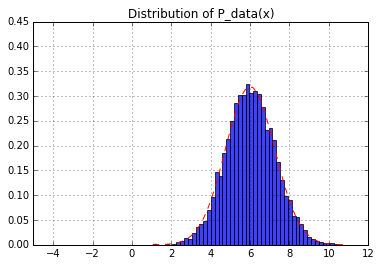

In [73]:

# the histogram of the data

plt.title('Distribution of P_data(x)')
n, bins1, patches = plt.hist( get_distribution_sampler(mu,sigma,10000)[:,0] ,50, normed=1,facecolor='blue', alpha=0.75)
y = mlab.normpdf(bins1,mu,sigma)
l = plt.plot(bins1,y,'r--', linewidth=1)
plt.axis([-5,12,0,0.45])
plt.grid(True)
plt.show()


 Epoch : 0, D: [8.1751277e-05, 0.99999994], G loss : 0.4803411066532135


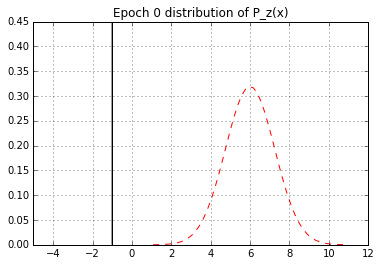

 Epoch : 500, D: [0.28838342, 0.89249998], G loss : 0.3426676392555237
 Epoch : 1000, D: [0.57786179, 0.64749998], G loss : 0.13438715040683746


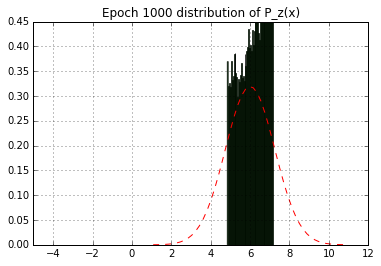

 Epoch : 1500, D: [0.6694876, 0.48250002], G loss : 0.14570048451423645
 Epoch : 2000, D: [0.64058459, 0.63249999], G loss : 0.15044642984867096


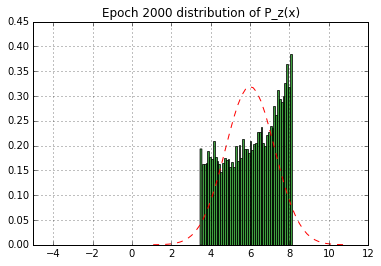

 Epoch : 2500, D: [0.6215443, 0.63499999], G loss : 0.15457263588905334
 Epoch : 3000, D: [0.65877545, 0.60000002], G loss : 0.15756335854530334


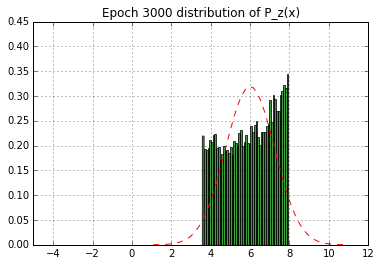

 Epoch : 3500, D: [0.63731134, 0.60749996], G loss : 0.1570904701948166
 Epoch : 4000, D: [0.64822555, 0.58999997], G loss : 0.12485712766647339


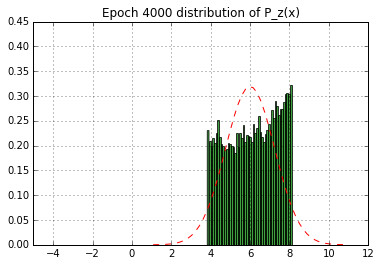

 Epoch : 4500, D: [0.63385111, 0.6225], G loss : 0.1453678011894226
 Epoch : 5000, D: [0.65499711, 0.565], G loss : 0.1682303249835968


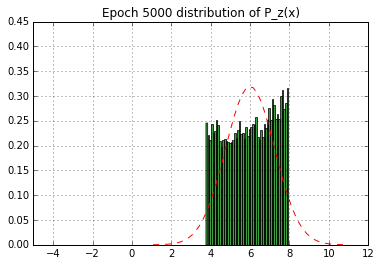

 Epoch : 5500, D: [0.64927411, 0.60000002], G loss : 0.13043364882469177
 Epoch : 6000, D: [0.64293575, 0.57499999], G loss : 0.1214110404253006


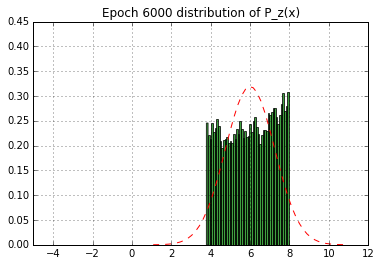

 Epoch : 6500, D: [0.64443117, 0.57249999], G loss : 0.12515366077423096
 Epoch : 7000, D: [0.6379149, 0.58249998], G loss : 0.16011154651641846


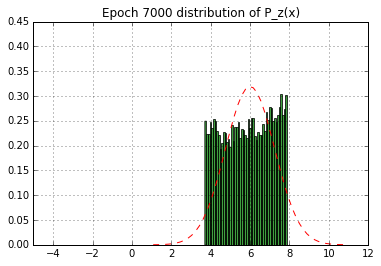

 Epoch : 7500, D: [0.67532384, 0.55749995], G loss : 0.13173243403434753
 Epoch : 8000, D: [0.65159267, 0.58249992], G loss : 0.16302241384983063


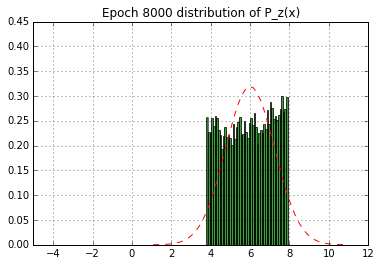

 Epoch : 8500, D: [0.64412814, 0.60249996], G loss : 0.1478886604309082
 Epoch : 9000, D: [0.64509267, 0.60750002], G loss : 0.1401572823524475


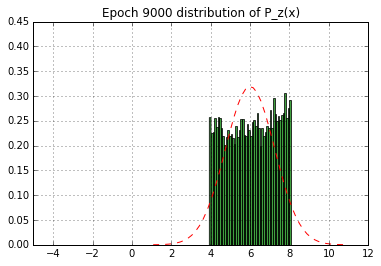

 Epoch : 9500, D: [0.63849711, 0.58749998], G loss : 0.13564376533031464
 Epoch : 10000, D: [0.65010715, 0.60249996], G loss : 0.1372705101966858


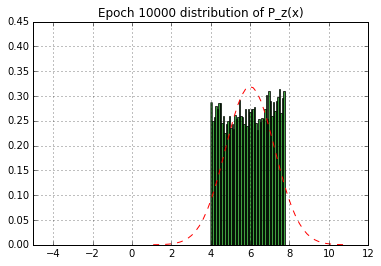

 Epoch : 10500, D: [0.64433527, 0.60500002], G loss : 0.1260291337966919
 Epoch : 11000, D: [0.63344783, 0.61500001], G loss : 0.15081509947776794


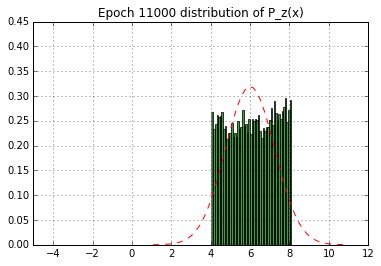

 Epoch : 11500, D: [0.62885964, 0.61999995], G loss : 0.13386885821819305
 Epoch : 12000, D: [0.63460934, 0.56999999], G loss : 0.14591656625270844


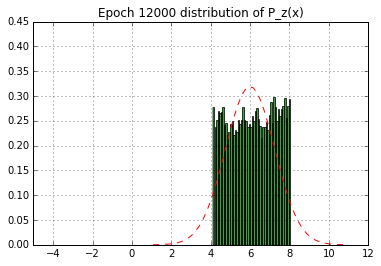

 Epoch : 12500, D: [0.64510828, 0.59500003], G loss : 0.14977717399597168
 Epoch : 13000, D: [0.62706816, 0.62], G loss : 0.15352663397789001


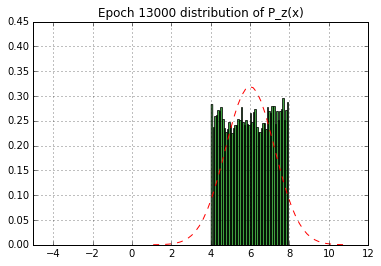

 Epoch : 13500, D: [0.64028627, 0.61249995], G loss : 0.15145404636859894
 Epoch : 14000, D: [0.62936771, 0.60750002], G loss : 0.14096225798130035


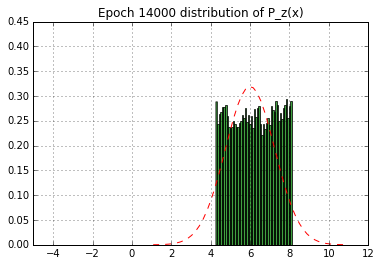

 Epoch : 14500, D: [0.64734817, 0.57999998], G loss : 0.1451524943113327
 Epoch : 15000, D: [0.654374, 0.60500002], G loss : 0.13255995512008667


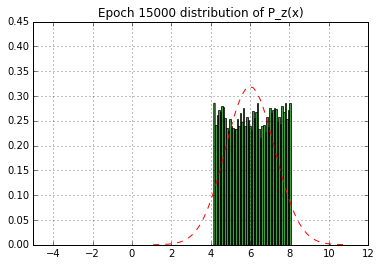

 Epoch : 15500, D: [0.63913399, 0.57749999], G loss : 0.15063698589801788
 Epoch : 16000, D: [0.64024842, 0.58249998], G loss : 0.1344555914402008


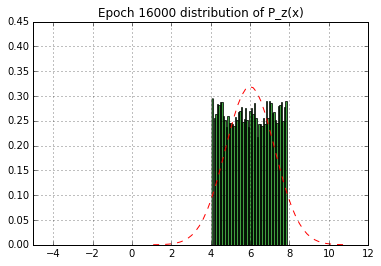

 Epoch : 16500, D: [0.64217055, 0.61250001], G loss : 0.14348922669887543
 Epoch : 17000, D: [0.65003908, 0.55999994], G loss : 0.1459617018699646


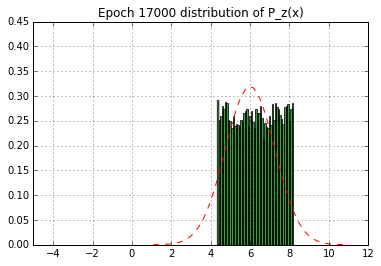

 Epoch : 17500, D: [0.62607884, 0.60999995], G loss : 0.16928327083587646
 Epoch : 18000, D: [0.63353634, 0.59999996], G loss : 0.14098745584487915


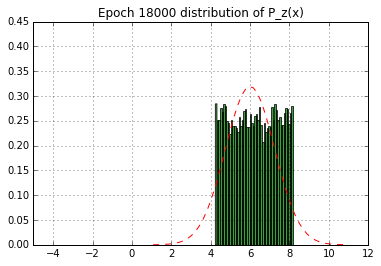

 Epoch : 18500, D: [0.65008658, 0.57999998], G loss : 0.13798318803310394
 Epoch : 19000, D: [0.65037972, 0.57999998], G loss : 0.14139452576637268


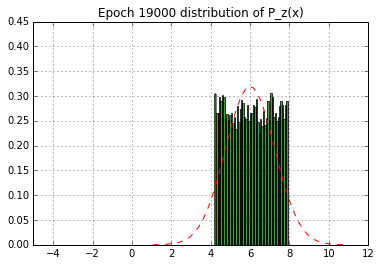

 Epoch : 19500, D: [0.62604463, 0.61249995], G loss : 0.1308732032775879
 Epoch : 20000, D: [0.63628727, 0.58999997], G loss : 0.14121726155281067


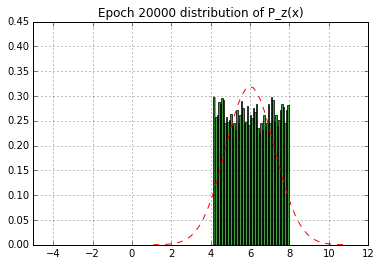

 Epoch : 20500, D: [0.62853038, 0.63999999], G loss : 0.15749619901180267
 Epoch : 21000, D: [0.62928426, 0.59499997], G loss : 0.1301276832818985


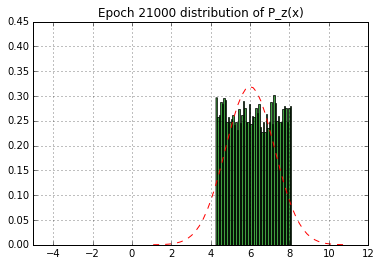

 Epoch : 21500, D: [0.64947611, 0.55000001], G loss : 0.13757659494876862
 Epoch : 22000, D: [0.64440054, 0.60750002], G loss : 0.15038080513477325


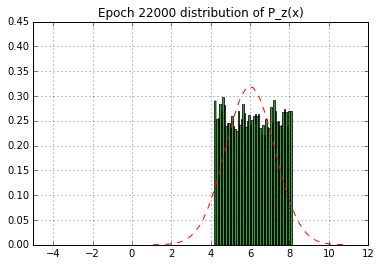

 Epoch : 22500, D: [0.62095726, 0.625], G loss : 0.15085065364837646
 Epoch : 23000, D: [0.63022983, 0.62], G loss : 0.14107434451580048


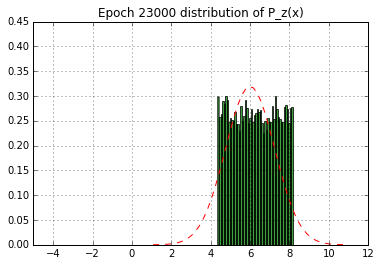

 Epoch : 23500, D: [0.62411249, 0.59499997], G loss : 0.15169274806976318
 Epoch : 24000, D: [0.65006381, 0.60249996], G loss : 0.14268356561660767


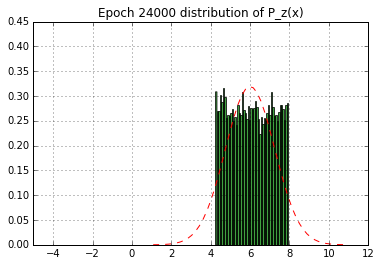

 Epoch : 24500, D: [0.62809592, 0.60000002], G loss : 0.13352355360984802
 Epoch : 25000, D: [0.62686163, 0.60249996], G loss : 0.14472128450870514


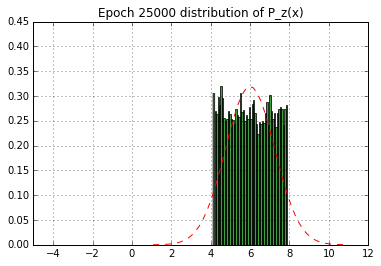

 Epoch : 25500, D: [0.63357872, 0.60749996], G loss : 0.1585460901260376
 Epoch : 26000, D: [0.63171816, 0.58749992], G loss : 0.14467407763004303


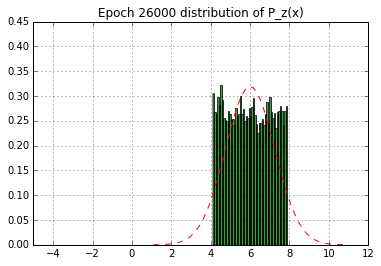

 Epoch : 26500, D: [0.6528604, 0.57499999], G loss : 0.15110351145267487
 Epoch : 27000, D: [0.63644505, 0.59249997], G loss : 0.14227202534675598


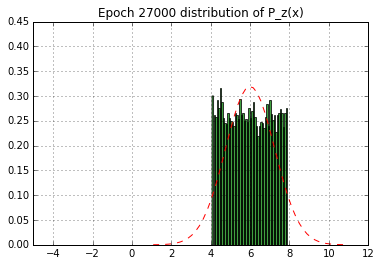

 Epoch : 27500, D: [0.6110822, 0.60749996], G loss : 0.1526235193014145
 Epoch : 28000, D: [0.66002208, 0.56], G loss : 0.15041205286979675


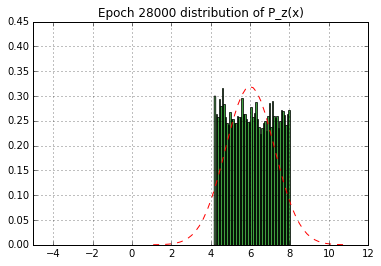

 Epoch : 28500, D: [0.61862117, 0.67499995], G loss : 0.145560622215271
 Epoch : 29000, D: [0.66230339, 0.53999996], G loss : 0.14702804386615753


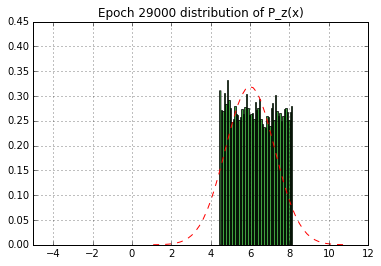

 Epoch : 29500, D: [0.62489206, 0.58999997], G loss : 0.14688386023044586
 Epoch : 30000, D: [0.6307767, 0.57999998], G loss : 0.13909600675106049


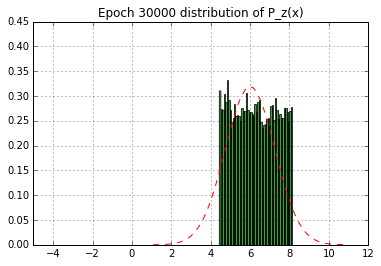

 Epoch : 30500, D: [0.64463699, 0.57999998], G loss : 0.1498163640499115
 Epoch : 31000, D: [0.63969868, 0.60749996], G loss : 0.1464545875787735


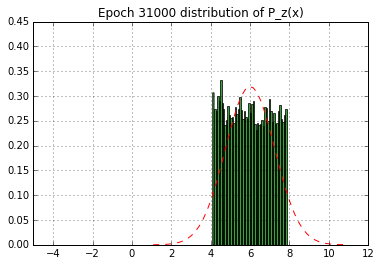

 Epoch : 31500, D: [0.62034267, 0.57749993], G loss : 0.15415923297405243
 Epoch : 32000, D: [0.64231342, 0.55999994], G loss : 0.16599921882152557


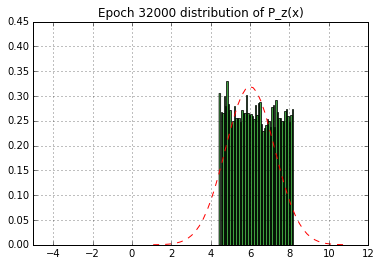

 Epoch : 32500, D: [0.63535213, 0.58499998], G loss : 0.16153785586357117
 Epoch : 33000, D: [0.65332228, 0.58999997], G loss : 0.15377861261367798


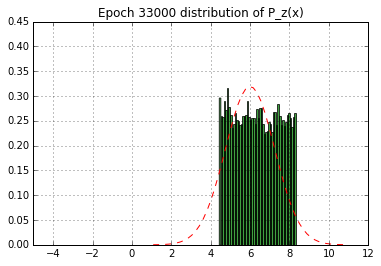

 Epoch : 33500, D: [0.64413244, 0.58499998], G loss : 0.1337907314300537
 Epoch : 34000, D: [0.61779815, 0.64750004], G loss : 0.14779222011566162


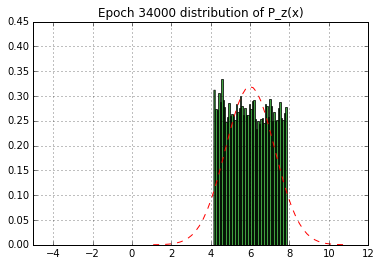

 Epoch : 34500, D: [0.61524159, 0.59499997], G loss : 0.16168347001075745
 Epoch : 35000, D: [0.64463401, 0.56249994], G loss : 0.14344628155231476


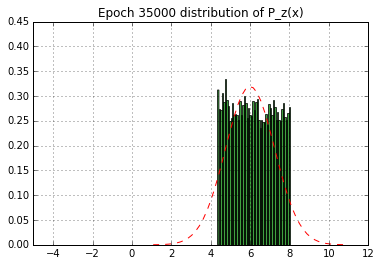

 Epoch : 35500, D: [0.65804762, 0.57749999], G loss : 0.14337250590324402
 Epoch : 36000, D: [0.63198692, 0.57749993], G loss : 0.14345189929008484


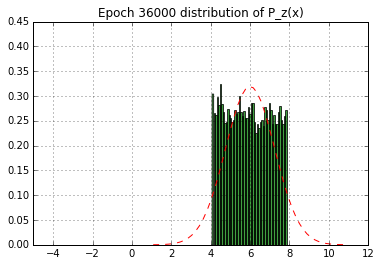

 Epoch : 36500, D: [0.62457395, 0.59499997], G loss : 0.14699210226535797
 Epoch : 37000, D: [0.63924068, 0.58250004], G loss : 0.14678822457790375


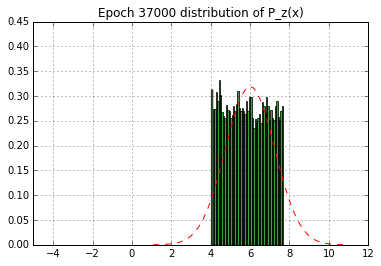

 Epoch : 37500, D: [0.63673317, 0.57250005], G loss : 0.15198104083538055
 Epoch : 38000, D: [0.63528788, 0.61000001], G loss : 0.15119841694831848


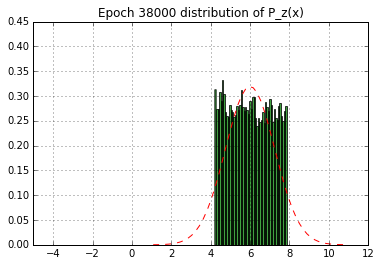

 Epoch : 38500, D: [0.63922709, 0.565], G loss : 0.1431247740983963
 Epoch : 39000, D: [0.6501084, 0.53750002], G loss : 0.15282757580280304


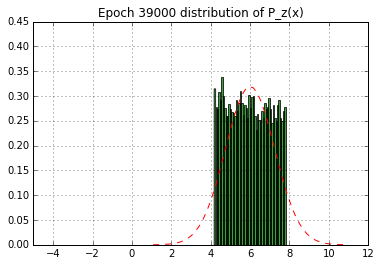

 Epoch : 39500, D: [0.58054, 0.66499996], G loss : 0.16499659419059753
 Epoch : 40000, D: [0.64489979, 0.59749997], G loss : 0.14766530692577362


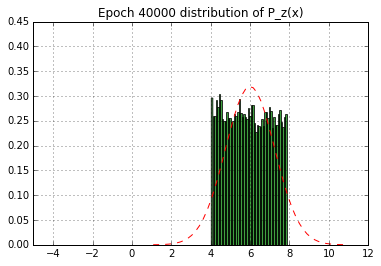

 Epoch : 40500, D: [0.66288406, 0.55499995], G loss : 0.15468350052833557
 Epoch : 41000, D: [0.64707255, 0.58249992], G loss : 0.1498216986656189


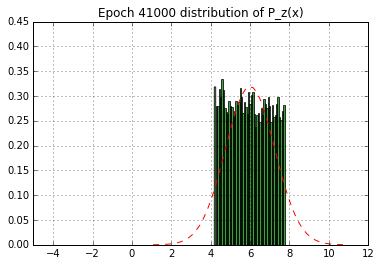

 Epoch : 41500, D: [0.63563108, 0.61249995], G loss : 0.14177851378917694
 Epoch : 42000, D: [0.63949144, 0.53749996], G loss : 0.14100921154022217


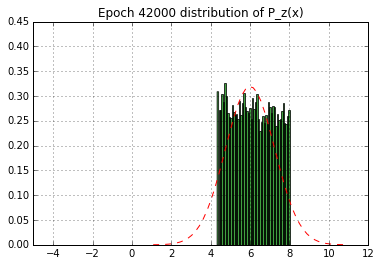

 Epoch : 42500, D: [0.6343171, 0.56999993], G loss : 0.17377367615699768
 Epoch : 43000, D: [0.64546299, 0.58999997], G loss : 0.14646239578723907


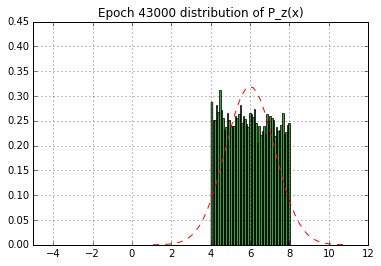

 Epoch : 43500, D: [0.63391596, 0.58500004], G loss : 0.15113498270511627
 Epoch : 44000, D: [0.62472212, 0.5625], G loss : 0.14351610839366913


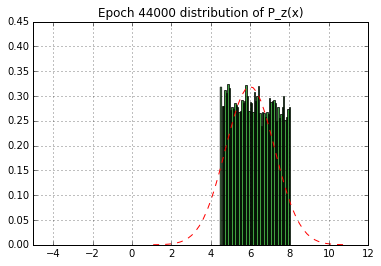

 Epoch : 44500, D: [0.64087403, 0.57249999], G loss : 0.15955449640750885


In [74]:

np_epoch = 45000
D_losses = []
GAN_losses = []

for epoch in range(np_epoch):

    for k in range(3):
        real_mb = get_distribution_sampler(mu,sigma,batch_size)
        fake_mb = np.hstack(
                    ( G.predict( np.random.uniform(0,1,batch_size)),
                        np.zeros(batch_size).reshape(batch_size,1))
                )
        train_D = np.vstack((real_mb, fake_mb))
        train_D = train_D[ np.random.permutation(train_D.shape[0]),:]
        train_Dx = train_D[:,0]
        train_Dy = np_utils.to_categorical(train_D[:,1],2)
        d_loss = D.train_on_batch(train_Dx,train_Dy)
        D_losses.append(d_loss)


    g_loss = GAN.train_on_batch( np.random.uniform(0,1,batch_size) , np_utils.to_categorical(np.ones(batch_size),2) )
    GAN_losses.append(g_loss)

    if epoch % print_interval == 0:
        print(" Epoch : {}, D: {}, G loss : {}".format(epoch,d_loss,g_loss))

    if epoch % 1000 == 0:
        fake = G.predict(Z1)
        plt.title('Epoch {} distribution of P_z(x)'.format(epoch))
        plt.hist(fake,50, normed=1, facecolor='green',alpha=0.75)
        l = plt.plot(bins1,y,'r--',linewidth=1)
        plt.axis([-5,12,0,0.45])
        plt.grid(True)
        plt.show()


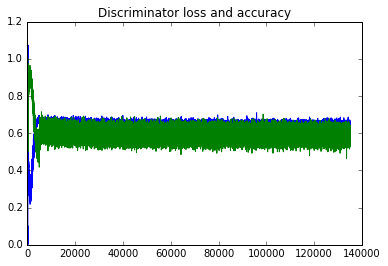

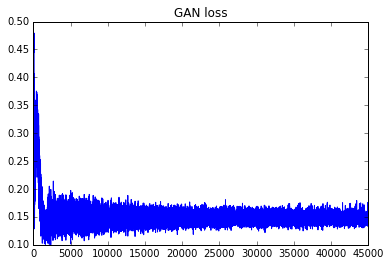

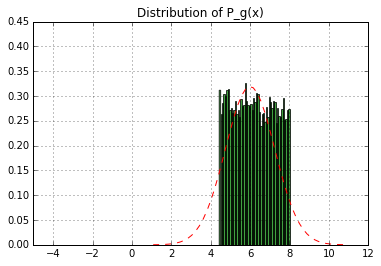

[[ 6.86425304]
 [ 6.86227322]
 [ 6.29797029]
 [ 7.62772131]
 [ 7.07837009]
 [ 6.24099779]
 [ 7.65395641]
 [ 7.36584806]
 [ 6.56334782]
 [ 6.10152912]]


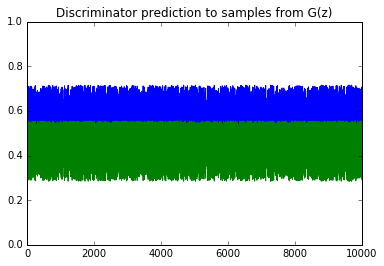

[[ 0.53227407  0.46772593]
 [ 0.53193134  0.46806866]
 [ 0.44911763  0.5508824 ]
 [ 0.65930349  0.34069648]
 [ 0.56909829  0.43090165]
 [ 0.45230958  0.54769045]
 [ 0.66338962  0.33661044]
 [ 0.61729562  0.38270435]
 [ 0.4800173   0.5199827 ]
 [ 0.46013945  0.53986055]]


In [75]:
plt.title('Discriminator loss and accuracy')    
plt.plot(D_losses)
plt.show()

plt.title('GAN loss')    
plt.plot(GAN_losses)
plt.show()

fake = G.predict(Z1)
plt.title('Distribution of P_g(x)')
plt.hist(fake, 50, normed=1, facecolor='green', alpha=0.75)
l = plt.plot(bins1, y, 'r--', linewidth=1)
plt.axis([-5, 12, 0, 0.45])
plt.grid(True)
plt.show()
print(fake[:10])

plt.title('Discriminator prediction to samples from G(z)')
detec = D.predict(fake)
plt.plot(detec)
plt.axis([0, 10000, 0, 1])
plt.show()
print(detec[:10])

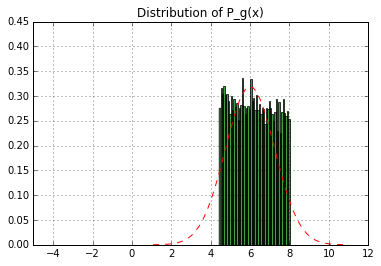

In [76]:
plt.title('Distribution of P_g(x)')
plt.hist(G.predict(np.random.uniform(0,1,10000)), 50, normed=1, facecolor='green', alpha=0.75)
l = plt.plot(bins1, y, 'r--', linewidth=1)
plt.axis([-5, 12, 0, 0.45])
plt.grid(True)
plt.show()
